In [1]:
import os, random, time
import cv2, imutils
from skimage.measure import compare_ssim
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
%cd '/Users/sharan_srinivasan/Documents/adhoc/kilaigal'

/Users/sharan_srinivasan/Documents/adhoc/kilaigal


1. Read a sample video stream
2. Fetch base frame,
3. Diff generator --> Identify motion changes, record ts and callback to chunk display
4. Process frames : BW,Guassian ablation, thresholding, countour detection --> Object localization. Callback to localized object image saver
5. end stream and output ts chunks. 
6. Try to output one frame of the localized object

In [50]:
def rmse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return np.sqrt(err)

# check the framedelta's rmse 
def compute_rmse_from_image_diff(imageDiff):
    diffSum = np.sum(imageDiff.astype('float')**2)
    diffCardinality = (imageDiff.shape[0]*imageDiff.shape[1])
    rmse = np.sqrt(diffSum/ diffCardinality)
    return rmse

# Check SSIM
def compute_structural_similarity(imgage, reference):
    s = compare_ssim(imgage, reference)
    return s


In [4]:
# Read the file and get an initial frame
vid = cv2.VideoCapture('videos/Water Drop-Small.mp4')

In [5]:
def simplePlay():
    cap = cv2.VideoCapture('videos/Water Drop-Small.mp4')

    while(cap.isOpened()):
        ret, frame = cap.read()

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #     gray = frame

        cv2.imshow('frame',gray)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break

    cap.release()
    cv2.destroyAllWindows()

In [19]:
def preProcessImageFrame(frame):
    # Resize the image so it plays nicely with openCV
    frame = imutils.resize(frame, width=512, height=256)
    # Convert it to grayscale to enable simple diffing
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Add some blur to smooth and get rid of noise
    frame = cv2.blur(frame, (1, 1), 0)
    return frame

In [52]:
def compare_images(imageA, imageB, title="simple"):
    # compute the mean squared error and structural similarity
    # index for the images
    m = rmse(imageA, imageB)
    s = compute_structural_similarity(imageA, imageB)

    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("RMSE: %.2f, SSIM: %.2f" % (m, s))

    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")

    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")

    # show the images
    plt.show()

Motion sequence detected on frame 53 with ssim distance 0.14252652290182788


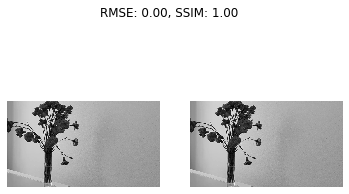

Motion sequence ended at frame [53]. Resetting State
Motion sequence detected on frame 163 with ssim distance 0.17069129616601053


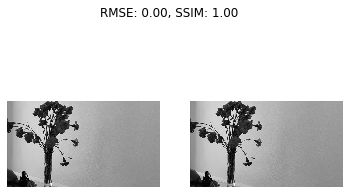

Motion sequence ended at frame [163]. Resetting State
Motion sequence detected on frame 218 with ssim distance 0.13372209138212166


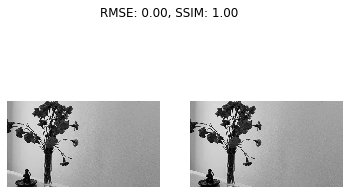

Motion sequence ended at frame [218]. Resetting State
Motion sequence detected on frame 273 with ssim distance 0.1767709719096553


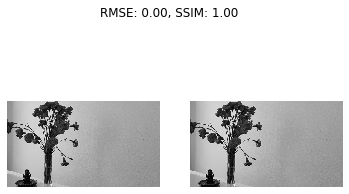

Motion sequence ended at frame [273]. Resetting State
Motion sequence detected on frame 658 with ssim distance 0.15809385449627833


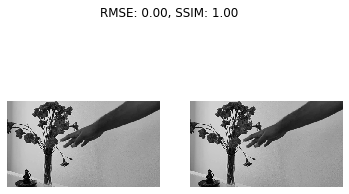

Motion sequence ended at frame [658]. Resetting State
Motion sequence detected on frame 691 with ssim distance 0.13714717060957937


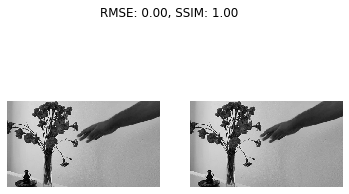

Motion sequence ended at frame [691]. Resetting State
Motion sequence detected on frame 735 with ssim distance 0.15465297559659208


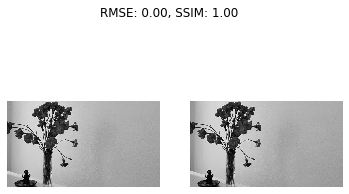

Motion sequence ended at frame [735]. Resetting State
Motion sequence detected on frame 757 with ssim distance 0.2148844460203383


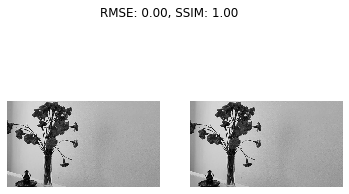

Motion sequence ended at frame [757]. Resetting State
Motion sequence detected on frame 856 with ssim distance 0.13253648206008717


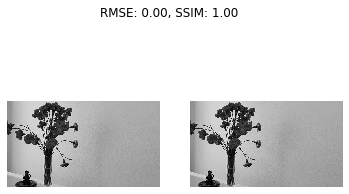

Motion sequence ended at frame [856]. Resetting State
Motion sequence detected on frame 955 with ssim distance 0.13941099631243814


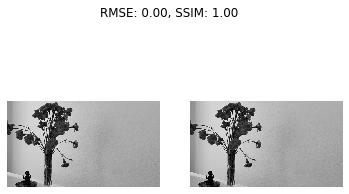

Motion sequence ended at frame [955]. Resetting State
Video stream not recieved. Aborting ...


In [54]:
all_motion_sequences = []
current_motion_seq = []
cap = cv2.VideoCapture('videos/flower_small.mp4')
baseFrame = None
SSIM_DISTANCE_THRESHOLD = 0.13
frame_num = 0 # codex frame index
motion_state = 0 # Whether the video is in motion


def fetch_frame_with_lag():    
    global frame_num
    i = frame_num
    while i < frame_num + 10:
        ret, nextFrame = cap.read()
        if ret == False:
            break;
        i+=1
    frame_num = i
    return ret, nextFrame

"""
    We update the base frame to adapt to the new normalcy. The intuition
    is that the over time the current frame will dampen precious base.
    X = (\alpha)X + (1-\alpha)C
    Where 
        - alpha : Affine smoothing weight
        - X: Existing base frame
        - C: Current frame
"""
def updateBaseFrameWithSmoothing(baseFrame, curFrame):
    #print("baseFrame", baseFrame.shape)
    #print("curFrame", curFrame.shape)
    alpha = 1.0
    newBaseFrame = alpha*baseFrame + (1-alpha)*curFrame
    # print("newBaseFrame", newBaseFrame.shape)
    return newBaseFrame.astype(int)
    

while(cap.isOpened()):
    # Get the current frame and preprocess it
    ret, frame = fetch_frame_with_lag()
    if(ret == False):
        if(motion_state == 1):
            print("Motion sequence ended at frame {}. Resetting State".format(current_motion_seq))
            all_motion_sequences.append(current_motion_seq)
            current_motion_seq = []
            motion_state = 0
        print("Video stream not recieved. Aborting ...")
        break;
        
    ppFrame = preProcessImageFrame(frame)

    if baseFrame is None:
        baseFrame = ppFrame.copy()
        continue
    else:
        # update the base frame
        alpha = 1.0
#         newBaseFrame = np.array(alpha*baseFrame + (1-alpha)*ppFrame).astype(int)
        newBaseFrame = cv2.addWeighted(baseFrame, 0.9, ppFrame, 0.1, 0, dtype = cv2.CV_8U)
        baseFrame = newBaseFrame.copy()
        
    # Determine if there is a motion sequence and update state
    ssim = 1 - compute_structural_similarity(baseFrame, ppFrame)
    if(ssim > SSIM_DISTANCE_THRESHOLD):
        current_motion_seq.append(frame_num)
        if(motion_state == 0):
            print("Motion sequence detected on frame {} with ssim distance {}".format(frame_num, ssim))
            motion_state = 1
            baseFrame = np.copy(ppFrame)
            compare_images(baseFrame, ppFrame)

    else:
        # When there is no motion, reset the state and end the motion seqeuence
        if(motion_state == 1):
            print("Motion sequence ended at frame {}. Resetting State".format(current_motion_seq))
            all_motion_sequences.append(current_motion_seq)
            current_motion_seq = []
            motion_state = 0
    
    frame_num +=1
    
    # To localize the Image
#     Get a simple diff with the base frame
    frameDelta = cv2.absdiff(baseFrame, ppFrame)
    # threshold the delta
    frameDeltaThresholded = cv2.threshold(frameDelta, 8, 255, cv2.THRESH_BINARY)
    
    # play the image
    cv2.imshow('frame',ppFrame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

cap.release()
cv2.destroyAllWindows()

In [32]:
def compress_all_sequences(all_motion_sequences):
    '''
    Takes a function of motion sequences and return (start_time) tuples.
    
    :param all_motion_sequences: A list of lists, with each list being a motion sequence
    :returns: A sequence of tuples
    '''
    
    compressed_sequences = []
    for s in all_motion_sequences:
        t = (s[0])
        compressed_sequences.append(t)
    return compressed_sequences
    
print(compress_all_sequences(all_motion_sequences))

[53, 86, 163, 185, 218, 240, 284, 460, 515, 647]


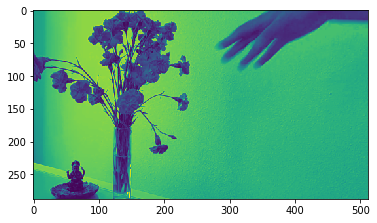

In [36]:
plt.imshow(baseFrame)

In [18]:
?cv2.addWeighted

numpy.ndarray